In [1]:
import os
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import torch
from typing import Literal
from PIL import Image
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
#!pip install git+https://github.com/facebookresearch/segment-anything.git

In [3]:
def dice_coef(groundtruth_mask, pred_mask):
    groundtruth_mask = groundtruth_mask.squeeze().numpy()  # Remove channel dimension and convert to numpy array
    pred_mask = pred_mask.squeeze().numpy()
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

In [4]:
# run ''' python batch_inference.py -i "data/BCSS_small/test/images" ''' first to generate inferenced masks in data/Results folder

_mask_transformer = transforms.Compose([
        transforms.PILToTensor(),
    ])
def get_masks(image_file, model_name="med_sam-vit_b", isTest=False):
    if isTest:
        gt_mask_file = os.path.join("../data/BCSS_small/test/masks/",image_file)
    else:
        gt_mask_file = os.path.join("../data/BCSS_small/train/masks/",image_file)
    gt_mask = Image.open(gt_mask_file)
    gt_mask = _mask_transformer(gt_mask)

    inference_mask_file = os.path.join("../data/Results", model_name, image_file)
    pred_mask = Image.open(inference_mask_file)    
    pred_mask = _mask_transformer(pred_mask)
    # print(gt_mask.unique())
    # print(pred_mask.unique())
    return gt_mask, pred_mask

In [5]:
test_images = [file for file in os.listdir("../data/BCSS_small/test/images") if file.endswith('.png')]
train_images = [file for file in os.listdir("../data/BCSS_small/train/images") if file.endswith('.png')]
gt_mask, pred = get_masks(train_images[0])

In [6]:
gt_mask

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [7]:
pred

tensor([[[0, 1, 0,  ..., 1, 1, 1],
         [0, 1, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 1,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

In [8]:
dice_coef(gt_mask, pred)

0.762

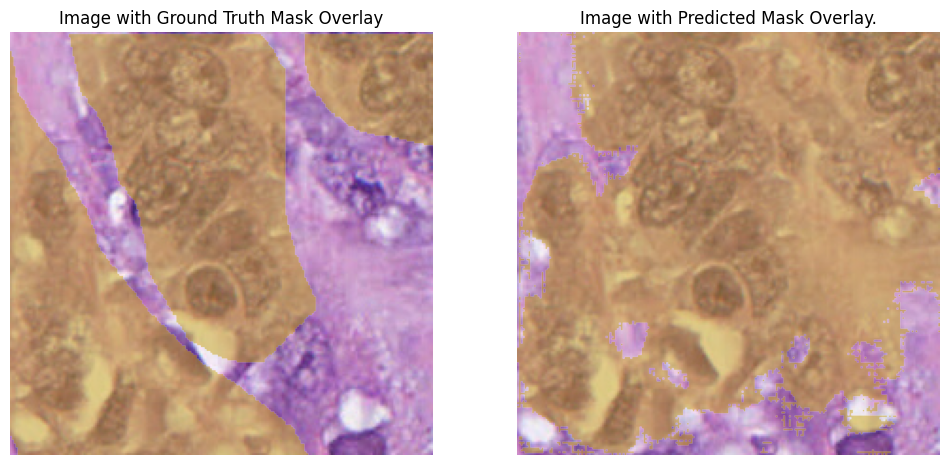

0.762

In [14]:
color_arr = np.random.random(3)
def show_mask(mask,color_arr=color_arr):
    ax = plt.gca()
    ax.set_autoscale_on(False)
    mask = (mask==1)
    img = np.ones((mask.shape[0], mask.shape[1], 4))
    img[:,:,3] = 0
    m = mask
    color_mask = np.concatenate([color_arr, [0.5]])
    img[m] = color_mask
    ax.imshow(img)
    
def plot_img(image_file, model_name="med_sam-vit_b", isTest=False):
    if isTest:
        path="../data/BCSS_small/test/images/"
    else: 
        path="../data/BCSS_small/train/images/"
    image_path = os.path.join(path, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mask,pred = get_masks(image_file, model_name=model_name, isTest=isTest)
    dice_coff = dice_coef(mask, pred) 

    mask_np = mask.squeeze().numpy()  # Remove channel dimension and convert to numpy array
    pred_np = pred.squeeze().numpy()
    plt.figure(figsize=(12, 6))

    # Plot GT mask
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    show_mask(mask_np)
    plt.title('Image with Ground Truth Mask Overlay')
    plt.axis('off')

    # Plot image with mask overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image)
    show_mask(pred_np)
    plt.title('Image with Predicted Mask Overlay.')
    plt.axis('off')

    plt.show()
    return dice_coff
plot_img(train_images[0])

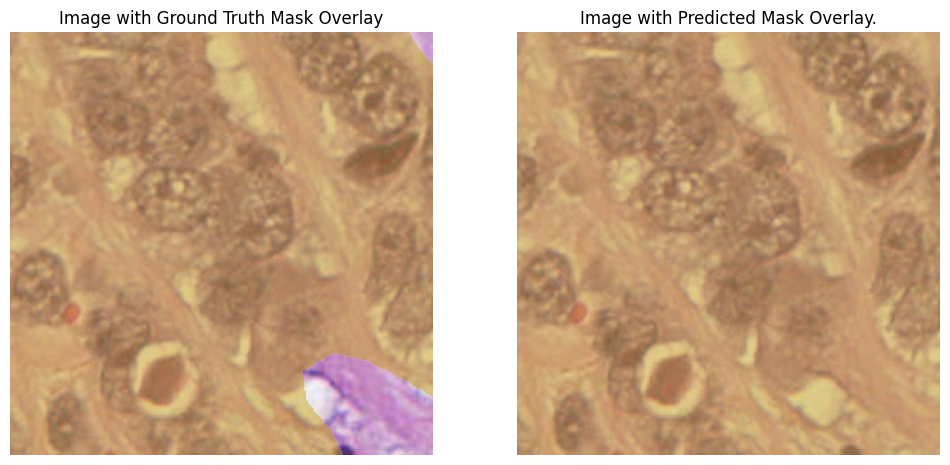

0.971

In [21]:
plot_img(test_images[3], model_name = "sam-vit_l", isTest=True)

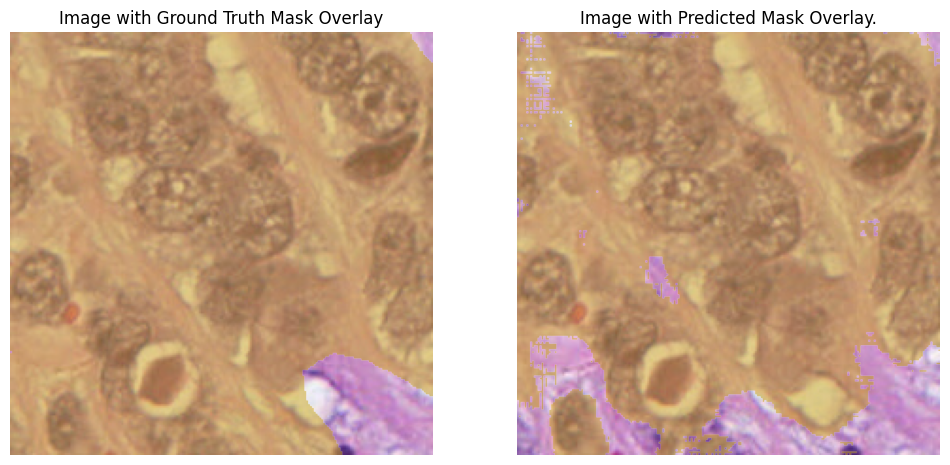

0.941

In [19]:
plot_img(test_images[3], model_name = "med_sam-vit_b", isTest=True)

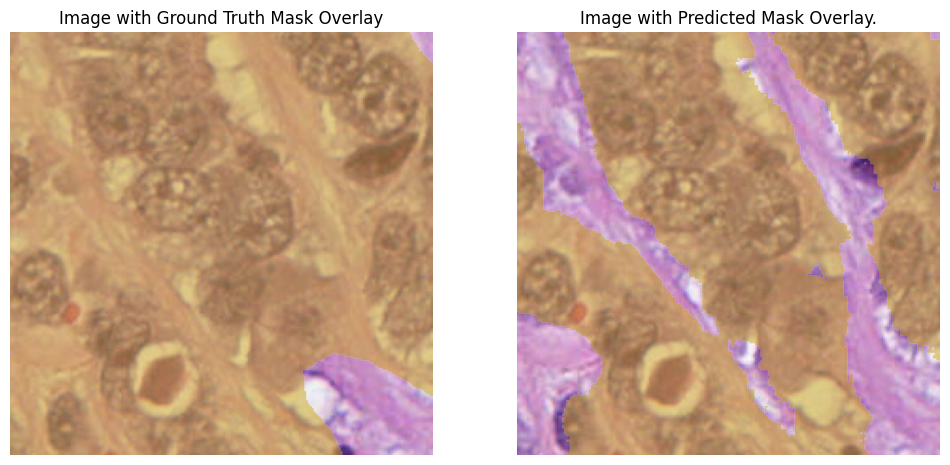

0.845

In [16]:
plot_img(test_images[3], model_name = "sam-vit_b-lora512", isTest=True)

In [18]:
image_path = "../data/BCSS_small/test/images/"
model_name = "med_sam-vit_b"
# mask_images = [os.path.join(image_path, filename) for filename in os.listdir(mask_path)]
dice_coff_list = []
for test_image in test_images:
    mask,pred = get_groundtruth_mask(test_image,model_name=model_name, isTest=True)
    dice_coff_list.append(dice_coef(mask, pred))

In [23]:
test_images

['TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_1120_2240_size224.png',
 'TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_1344_2016_size224.png',
 'TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_1344_2464_size224.png',
 'TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_1344_3136_size224.png',
 'TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_1568_2016_size224.png',
 'TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_1792_3136_size224.png',
 'TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_2016_1344_size224.png',
 'TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_2240_0_size224.png',
 'TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_2240_1120_size224.png',
 'TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_2240_448_size224.png',
 'TCGA-A1-A0SK-DX1_xmin45749_ymin25055_MPP-0_896_3136_size224.png']

In [19]:
dice_coff_list

[0.765, 0.849, 0.686, 0.941, 0.41, 0.931, 0.0, 0.774, 0.717, 0.894, 0.91]

In [21]:
def is_tuple_of_ints(var):
    """
    Checks if a variable is a tuple and contains only integers.

    Args:
        var: The variable to check.

    Returns:
        True if the variable is a tuple and contains only integers, False otherwise.
    """
    if not isinstance(var, tuple):
        return False
    for element in var:
        if not isinstance(element, int):
            return False
    return True

In [22]:
request= {'p1': '(200,1300)', 'p2': '3900,1600', 'alpha': '0.3', 'model': 'sam-vit_h'}
try:
    point1 = tuple(map(int, request["p1"].strip('()').split(','))) 
    point2 = tuple(map(int, request["p2"].strip('()').split(',')))
    print(point1)
    print(point2)
except Exception as e:
    print(e)
alpha = float(request["alpha"]) if "alpha" in request else None
model = request["model"] if "model" in request else "med_sam-vit_b"
if point1 and not is_tuple_of_ints(point1):
    print("Invalid point input. p1={}".format(point1))
elif (not point1 and point2) or (point2 and not is_tuple_of_ints(point2)):
    print("Invalid box input. p2={}")


(200, 1300)
(3900, 1600)
